# F1 Racing Analysis

## Table of Contents

1. [Problem Statement](#1---problem-statement)
2. [Data Loading and Preprocessing](#2---data-loading-and-preprocessing)
3. [Exploratory Data Analysis](#3---exploratory-data-analysis)
4. [Baseline Models](#4---baseline-models)
5. [Baseline Interpretation](#5---baseline-interpretation)
6. [Final Model Pipeline](#6---final-model-pipeline)

---

## 1 - Problem Statement


### Research Question

Can we predict F1 race outcomes using qualifying position, circuit characteristics, and constructor performance?

**Primary Goals:**
- Predict final race position (regression)
- Predict whether a driver scores points (classification)

**Why this matters:** F1 teams spend millions on strategy. Understanding what factors most influence race outcomes helps with race-day decisions, resource allocation, and performance analysis.

**Success Metrics:**
- Regression: RMSE, MAE, R²
- Classification: Accuracy, Precision, Recall, AUC

---

In [2]:
# Data and Stats
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'

## 2 - Data Loading and Preprocessing

### The Dataset

Dataset from Kaggle with F1 data from 1950-2024. 14 CSV files covering races, drivers, constructors, circuits, qualifying, lap times, pit stops, and standings.

**Key files**:
- `results.csv` - race results, points, positions
- `races.csv` - race info, dates, circuits
- `qualifying.csv` - qualifying results and grid positions
- `drivers.csv` - driver info
- `constructors.csv` - team info
- `circuits.csv` - circuit details


### Load the Data

In [3]:
datasets_path = 'datasets'

results = pd.read_csv(os.path.join(datasets_path, 'results.csv'))
races = pd.read_csv(os.path.join(datasets_path, 'races.csv'))
qualifying = pd.read_csv(os.path.join(datasets_path, 'qualifying.csv'))
drivers = pd.read_csv(os.path.join(datasets_path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(datasets_path, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(datasets_path, 'circuits.csv'))

results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### Merge Datasets

Merge datasets to combine race results with qualifying, driver info, circuits, and constructor data.

In [4]:
df = results.copy().drop(columns=['position']).rename(columns={'positionOrder': 'position'})

qual = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'})
df = pd.merge(df, qual, on=['raceId', 'driverId'], how='left')

races_circuits = pd.merge(races, circuits[['circuitId', 'circuitRef', 'name', 'country']], on='circuitId', how='left')
df = pd.merge(df, races_circuits[['raceId', 'year', 'round', 'circuitId', 'circuitRef', 'country']], on='raceId', how='left')

drivers_df = drivers[['driverId', 'driverRef']]
df = pd.merge(df, drivers_df, on='driverId', how='left')

constructors_df = constructors[['constructorId', 'name']].rename(columns={'name': 'constructor_name'})
df = pd.merge(df, constructors_df, on='constructorId', how='left')

# Drop all post race results except the ones we are trying to predict
df = df.drop(columns=['positionText', 'laps', 'time', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'rank', 'statusId'])

# Number is irrelevant for prediction
df = df.drop(columns=['number'])

df.head()

,resultId,raceId,driverId,constructorId,grid,position,points,qualifying_position,year,round,circuitId,circuitRef,country,driverRef,constructor_name
0,1,18,1,1,1,1,10.0,1.0,2008,1,1,albert_park,Australia,hamilton,McLaren
1,2,18,2,2,5,2,8.0,5.0,2008,1,1,albert_park,Australia,heidfeld,BMW Sauber
2,3,18,3,3,7,3,6.0,7.0,2008,1,1,albert_park,Australia,rosberg,Williams
3,4,18,4,4,11,4,5.0,12.0,2008,1,1,albert_park,Australia,alonso,Renault
4,5,18,5,1,3,5,4.0,3.0,2008,1,1,albert_park,Australia,kovalainen,McLaren


### Basic Data Cleaning and Preparation
Make sure that the numeric columns are actually numeric, and filter out the clearly invalid rows. Also add a scored_points and a position_gain row, representing whether or not the driver has scored any points in the race and how many positions driver has gained from start to end.

In [5]:
numeric_cols_to_convert = [
    "position", "grid", "points", "qualifying_position",
    "year", "round", "circuitId", "resultId", "raceId",
    "driverId", "constructorId"
]

for col in numeric_cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df[df["position"].notna() & (df["position"] > 0)]

df = df[df["points"].notna()]

df["scored_points"] = (df["points"] > 0).astype(int)
df['position_gain'] = df['grid'] - df['position']


### Missingness

There are several missing values across different columns:

In [6]:
df.isna().sum()

resultId                   0
raceId                     0
driverId                   0
constructorId              0
grid                       0
position                   0
points                     0
qualifying_position    16265
year                       0
round                      0
circuitId                  0
circuitRef                 0
country                    0
driverRef                  0
constructor_name           0
scored_points              0
position_gain              0
dtype: int64

There are a lot of missing values in qualfying position. General knowledge about F1 can be used to impute these values. They are likely missing because the driver did not participate in the qualification round, or did not set a lap. This can also be seen in the csv files. The fuile qualifying.csv has entries for all of the same races as the other csv files, but has less data. Thus, the missing values are likely to be drivers that have qualified for the last position (20) one way or another, so imputation can be done accordingly.

In [7]:
df['qualifying_position'] = df['qualifying_position'].fillna(20)

df.isna().sum()

resultId               0
raceId                 0
driverId               0
constructorId          0
grid                   0
position               0
points                 0
qualifying_position    0
year                   0
round                  0
circuitId              0
circuitRef             0
country                0
driverRef              0
constructor_name       0
scored_points          0
position_gain          0
dtype: int64

## 3 - Exploratory Data Analysis

The goal of this EDA is to understand which features are most predictive of race outcomes. This will inform our feature selection and model choices.

### Brief Data Overview

In [8]:
display(df.head())
display(df.info())
display(df.describe())

,resultId,raceId,driverId,constructorId,grid,position,points,qualifying_position,year,round,circuitId,circuitRef,country,driverRef,constructor_name,scored_points,position_gain
0,1,18,1,1,1,1,10.0,1.0,2008,1,1,albert_park,Australia,hamilton,McLaren,1,0
1,2,18,2,2,5,2,8.0,5.0,2008,1,1,albert_park,Australia,heidfeld,BMW Sauber,1,3
2,3,18,3,3,7,3,6.0,7.0,2008,1,1,albert_park,Australia,rosberg,Williams,1,4
3,4,18,4,4,11,4,5.0,12.0,2008,1,1,albert_park,Australia,alonso,Renault,1,7
4,5,18,5,1,3,5,4.0,3.0,2008,1,1,albert_park,Australia,kovalainen,McLaren,1,-2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   resultId             26759 non-null  int64  
 1   raceId               26759 non-null  int64  
 2   driverId             26759 non-null  int64  
 3   constructorId        26759 non-null  int64  
 4   grid                 26759 non-null  int64  
 5   position             26759 non-null  int64  
 6   points               26759 non-null  float64
 7   qualifying_position  26759 non-null  float64
 8   year                 26759 non-null  int64  
 9   round                26759 non-null  int64  
 10  circuitId            26759 non-null  int64  
 11  circuitRef           26759 non-null  object 
 12  country              26759 non-null  object 
 13  driverRef            26759 non-null  object 
 14  constructor_name     26759 non-null  object 
 15  scored_points        26759 non-null 

None

,resultId,raceId,driverId,constructorId,grid,position,points,qualifying_position,year,round,circuitId,scored_points,position_gain
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000
mean,13380.977391,551.687283,278.673530,50.180537,11.134796,12.794051,1.987632,16.547292,1991.394372,8.511192,23.820808,0.305318,-1.659255
std,7726.134642,313.265036,282.703039,61.551498,7.202860,7.665951,4.351209,5.817798,19.952885,5.070231,19.112002,0.460551,9.613308
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1950.000000,1.000000,1.000000,0.000000,-39.000000
25%,6690.500000,300.000000,57.000000,6.000000,5.000000,6.000000,0.000000,14.000000,1977.000000,4.000000,9.000000,0.000000,-5.000000
50%,13380.000000,531.000000,172.000000,25.000000,11.000000,12.000000,0.000000,20.000000,1991.000000,8.000000,18.000000,0.000000,0.000000
75%,20069.500000,811.000000,399.500000,63.000000,17.000000,18.000000,2.000000,20.000000,2009.000000,12.000000,34.000000,1.000000,4.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,39.000000,50.000000,28.000000,2024.000000,24.000000,80.000000,1.000000,30.000000


### General Numbers

How does the data look? What's the general feel of the numbers?

In [9]:
overview = {
    "Total race results": len(df),
    "Unique races": df['raceId'].nunique(),
    "Unique drivers": df['driverId'].nunique(),
    "Unique constructors": df['constructorId'].nunique(),
    "Unique circuits": df['circuitRef'].nunique(),
    "Time period (min year)": df['year'].min(),
    "Time period (max year)": df['year'].max(),
}

for k, v in overview.items():
    print(f"{k}: {v}")

Total race results: 26759
Unique races: 1125
Unique drivers: 861
Unique constructors: 211
Unique circuits: 77
Time period (min year): 1950
Time period (max year): 2024


### Target Exploration


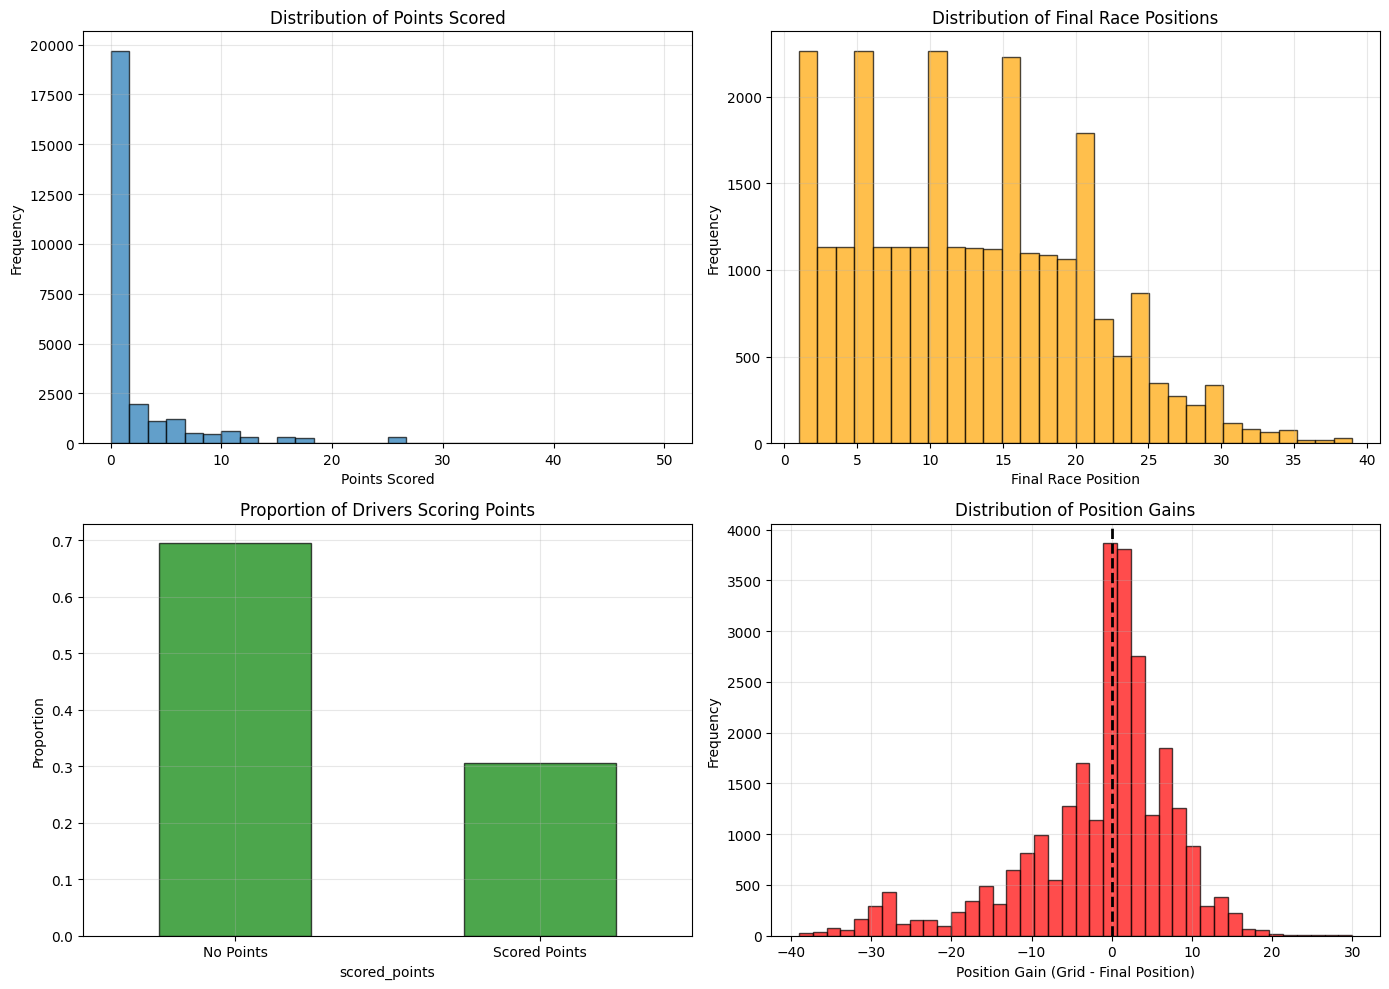

Zero points: 69.5%
Non-zero points: 30.5%


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Points distribution
axes[0, 0].hist(df['points'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Points Scored')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Points Scored')
axes[0, 0].grid(True, alpha=0.3)

# Final race position distribution
axes[0, 1].hist(df['position'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Final Race Position')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Final Race Positions')
axes[0, 1].grid(True, alpha=0.3)

# Proportion of drivers scoring points
df['scored_points'].value_counts(normalize=True).plot(
    kind='bar', ax=axes[1, 0], edgecolor='black', alpha=0.7, color='green'
)
axes[1, 0].set_title("Proportion of Drivers Scoring Points")
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['No Points', 'Scored Points'], rotation=0)
axes[1, 0].set_ylabel("Proportion")
axes[1, 0].grid(True, alpha=0.3)

# Position gain distribution
axes[1, 1].hist(df['position_gain'], bins=40, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Position Gain (Grid - Final Position)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Position Gains')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ratios = df['scored_points'].value_counts(normalize=True)
print(f"Zero points: {ratios[0] * 100:.1f}%")
print(f"Non-zero points: {ratios[1] * 100:.1f}%")


Points distribution is highly skewed with many zeros, indicating class imbalance. Position distributions show expected patterns with more drivers finishing in lower positions. Proportion of drivers scoring points shows that the number of drivers scoring is not balanced with the number of drivers not scoring. This means that there is a need for oversampling/undersampling to balance classes when predicting if a driver scores or not.

### Driver-Level Insights

These match with what generally happens in F1.

In [11]:
driver_summary = (
    df.groupby('driverRef')
      .agg(
          races=('raceId','count'),
          total_points=('points','sum'),
          avg_points=('points','mean'),
          avg_position=('position','mean')
      )
      .sort_values('avg_points', ascending=False)
)

driver_summary.head(10)

,races,total_points,avg_points,avg_position
driverRef,,,,
max_verstappen,209,2912.5,13.935407,5.645933
hamilton,356,4820.5,13.540730,5.019663
vettel,300,3098.0,10.326667,7.093333
leclerc,149,1363.0,9.147651,7.557047
rosberg,206,1594.5,7.740291,8.252427
piastri,46,347.0,7.543478,7.891304
norris,128,950.0,7.421875,7.851562
bottas,247,1788.0,7.238866,8.967611
george_amick,1,6.0,6.000000,2.000000


### Constructor-Level Insights

These match with what generally happens in F1.

In [12]:
constructor_summary = (
    df.groupby('constructor_name')
      .agg(
          races=('raceId','count'),
          total_points=('points','sum'),
          avg_points=('points','mean'),
      )
      .sort_values('total_points', ascending=False)
)

constructor_summary.head(10)

,races,total_points,avg_points
constructor_name,,,
Ferrari,2439,11091.27,4.547466
Mercedes,652,7730.64,11.856810
Red Bull,788,7673.00,9.737310
McLaren,1923,7022.50,3.651846
Williams,1676,3641.00,2.172434
Renault,787,1777.00,2.257942
Force India,424,1098.00,2.589623
Team Lotus,871,995.00,1.142365
Benetton,520,861.50,1.656731


Top teams like Ferrari and Mercedes average much better finishes than backmarker teams. This difference shows constructor performance significantly impacts race outcomes, justifying its inclusion as a feature.

### Qualifying vs Race Performance

Correlation: 0.744


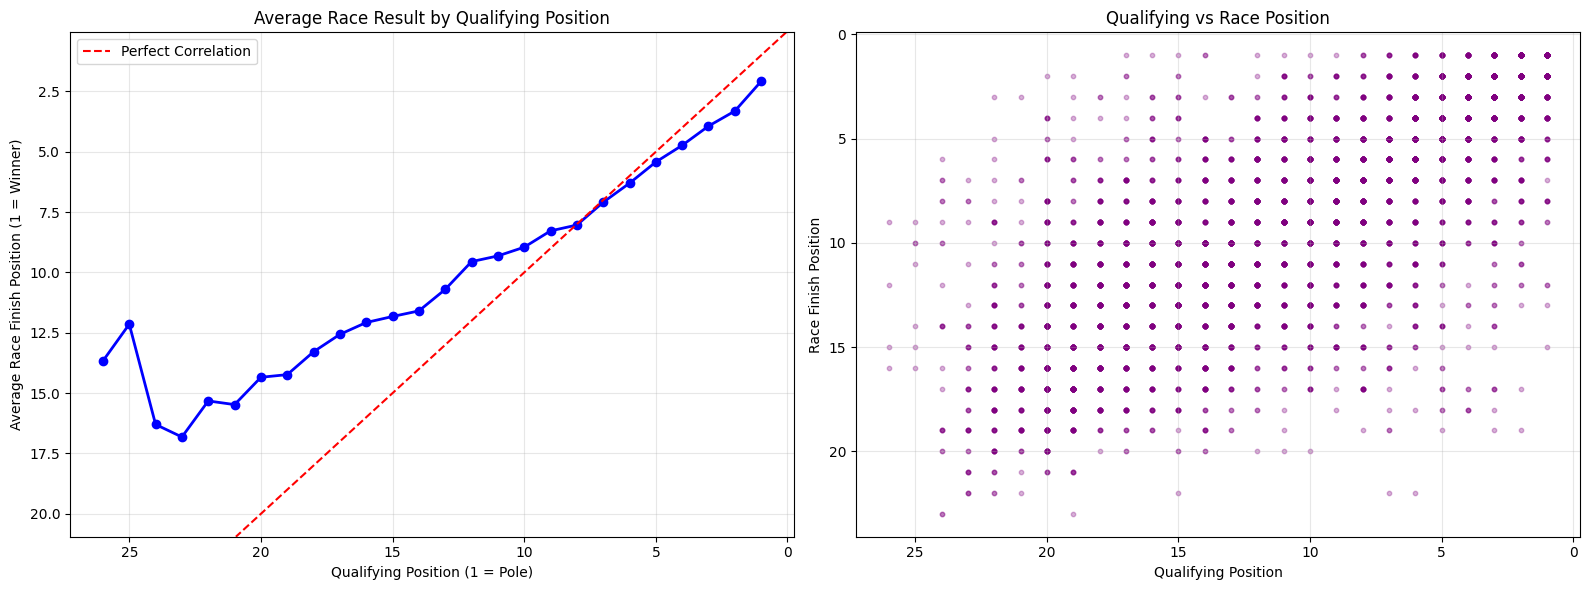

In [13]:
tmp = pd.merge(results, qualifying[['raceId', 'driverId', 'position']], 
               on=['raceId', 'driverId'], how='inner')
tmp = tmp.rename(columns={'position_x': 'race_position', 'position_y': 'qualifying_position'})

for col in ['race_position', 'qualifying_position']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['race_position', 'qualifying_position'])
tmp = tmp[(tmp['race_position'] > 0) & (tmp['qualifying_position'] > 0)]

correlation = tmp[['qualifying_position', 'race_position']].corr()
print(f"Correlation: {correlation.loc['qualifying_position', 'race_position']:.3f}")

avg_finish = tmp.groupby('qualifying_position')['race_position'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(avg_finish['qualifying_position'], avg_finish['race_position'], 
         marker='o', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel("Qualifying Position (1 = Pole)")
ax1.set_ylabel("Average Race Finish Position (1 = Winner)")
ax1.set_title("Average Race Result by Qualifying Position")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.axline((1, 1), (20, 20), color='red', linestyle='--', label='Perfect Correlation')
ax1.legend()

scatter_data = tmp.sample(min(5000, len(tmp)))
ax2.scatter(scatter_data['qualifying_position'], scatter_data['race_position'], 
           alpha=0.3, s=10, color='purple')
ax2.set_xlabel("Qualifying Position")
ax2.set_ylabel("Race Finish Position")
ax2.set_title("Qualifying vs Race Position")
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The left plot shows pole sitters average around P2 finish, while back-of-grid qualifiers average P15+. The scatter plot shows the spread of outcomes for each qualifying position. There is a strong positive correlation between qualifying position and finishing position. This fits well with what usually happens in F1 races. 

### Circuit Analysis

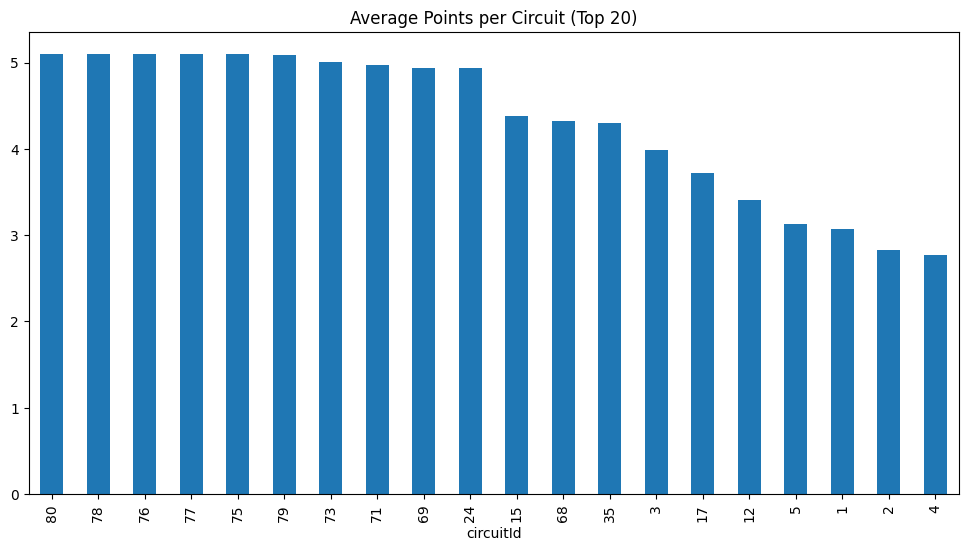

In [14]:
circuit_points = df.groupby('circuitId')['points'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
circuit_points.head(20).plot(kind='bar')
plt.title("Average Points per Circuit (Top 20)")
plt.show()

Different circuits have different conditions, and this has a great effect on drivers' performances. The variation in the points won from circuit to circuit demonstrates this.

### Correlation Analysis


In [15]:
id_cols = [
    'resultId', 'raceId', 'driverId', 'constructorId',
    'circuitId'
]

result_cols = [
    'points', 'position_gain', 'scored_points'
]

numeric_cols = df.select_dtypes(include=['int64','float64']).columns
numeric_cols = numeric_cols.drop(id_cols)
numeric_cols = numeric_cols.drop(result_cols)

corr_position = df[numeric_cols].corr()['position'].sort_values(ascending=False)

print("Correlation of position with other features:")
display(corr_position)

Correlation of position with other features:


position               1.000000
qualifying_position    0.321537
grid                   0.165097
round                 -0.020986
year                  -0.107401
Name: position, dtype: float64

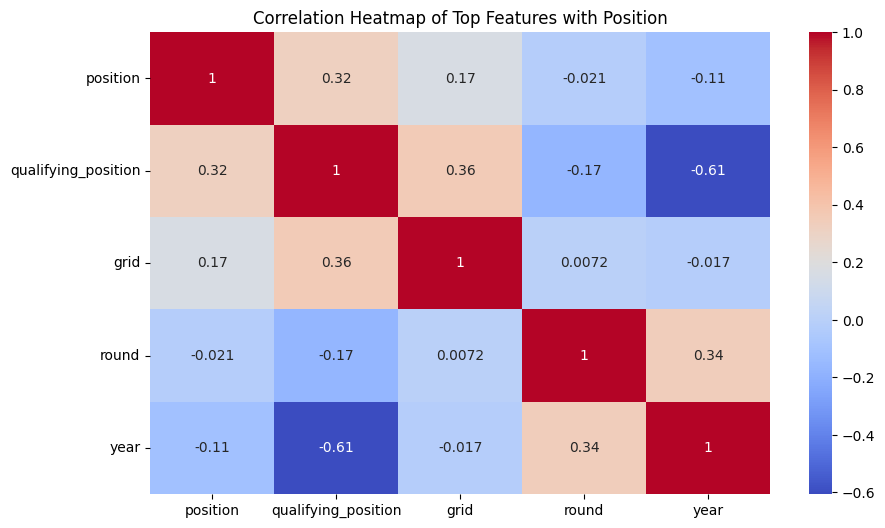

In [16]:
top_position = corr_position.abs().index

plt.figure(figsize=(10,6))
sns.heatmap(df[top_position].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Top Features with Position")
plt.show()

The exploratory analysis helps show why certain features were selected for the modeling. The strong correlations between qualifying positon and final race position being approximately 0.32 shows that qualifying performance is the strongest predictor of finishing result. Because qualifying positon reflects the raw pace without any other randomness, it also serves as a more reliable variable than grid position.

### EDA Summary and Feature Engineering Rationale

**Key Findings (with supporting evidence):**

2. **Qualifying position** shows 0.32 correlation with final position (see correlation matrix above)
3. **Points distribution** is imbalanced: 69.5% zero points, 30.5% scored (printed output above)
4. **Circuit effects** points vary significantly from circuit to circuit (see circuit chart)
5. **Constructor matters**: average/total points vary significantly between constructors (see constructor chart)
6. **Driver matters**: average/total points vary significantly between drivers (see driver chart)

**Encoding Strategy:**
- **One-hot encoding** for `circuitId`, `driverId` and `constructorId`: These are categorical variables with no inherent ordering. One-hot encoding creates binary features (0/1) for each category, allowing the model to learn distinct effects for each circuit and constructor.

**Model Selection Rationale from EDA:**
- The scatter plot (Qualifying vs Race Position) shows a roughly linear relationship with correlation r=0.744
- This suggests linear models (Linear Regression, Ridge) are appropriate baselines
- However, the spread around the line indicates non-linearity, justifying alternative models


## 4 - Baseline Models


We start with simple, interpretable models to establish performance benchmarks.

**Model 1: Linear Regression** for position prediction
- Target: Final race position (continuous)
- Features: grid, circuitRef, constructorId

**Model 2: Logistic Regression** for points classification
- Target: Whether driver scored points (binary)
- Features: grid, circuitRef, constructorId

**Why these baselines:**
- EDA showed linear relationship between grid and position (r=0.65)
- Interpretable coefficients help understand feature importance
- Fast to train, easy to debug
- Provides benchmark for more complex models

In [17]:
features_to_use = ['driverId', 'constructorId', 'grid', 'qualifying_position', 'year', 'round', 'circuitId']
X = df[features_to_use].copy()
X_encoded = pd.get_dummies(X, columns=['driverId',  'constructorId', 'circuitId'], drop_first=True)

y_position = df['position']
y_points_binary = df['scored_points']

print(f"Dataset: {X_encoded.shape[0]:,} samples, {X_encoded.shape[1]} features")
print(f"Points: {y_points_binary.sum():,} scored ({(y_points_binary.sum()/len(y_points_binary)*100):.1f}%), {(len(y_points_binary) - y_points_binary.sum()):,} no points ({((len(y_points_binary) - y_points_binary.sum())/len(y_points_binary)*100):.1f}%)")


Dataset: 26,759 samples, 1150 features
Points: 8,170 scored (30.5%), 18,589 no points (69.5%)


### Linear Regression for Race Position

Test RMSE: 2946093498.510
Test MAE: 72171325.266
Test R²: -146175931651187648.000

Top features:
                feature          coef
526        driverId_524  1.927841e+11
975   constructorId_115  1.927841e+11
1015  constructorId_155  1.477756e+11
771        driverId_769  1.477756e+11
82          driverId_80  9.323248e+10
402        driverId_400  8.068042e+10
1051  constructorId_192  8.068042e+10
444        driverId_442  6.244346e+10
1036  constructorId_177  6.244346e+10
958    constructorId_98  5.435291e+10


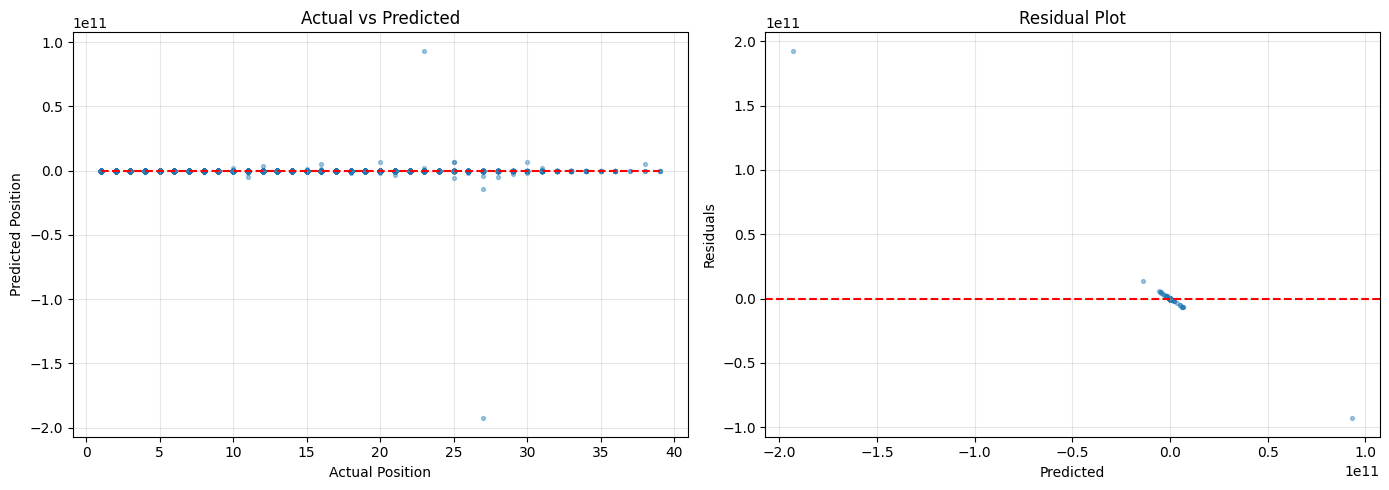

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_position, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")

feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr.coef_)
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, y_pred_test, alpha=0.4, s=8)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1.5)
axes[0].set_xlabel('Actual Position')
axes[0].set_ylabel('Predicted Position')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.4, s=8)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Logistic Regression for Points Classification


Test Accuracy: 0.761

Classification Report:
               precision    recall  f1-score   support

    No Points       0.88      0.76      0.82      3718
Scored Points       0.58      0.76      0.66      1634

     accuracy                           0.76      5352
    macro avg       0.73      0.76      0.74      5352
 weighted avg       0.79      0.76      0.77      5352


Top features:
               feature      coef
991  constructorId_131  2.267717
906   constructorId_45  2.216701
847       driverId_846  2.165981
104       driverId_102  1.980516
119       driverId_117  1.839165
306       driverId_304  1.727567
901   constructorId_39  1.727475
915   constructorId_54  1.692085
910   constructorId_49  1.671992
904   constructorId_42  1.639043


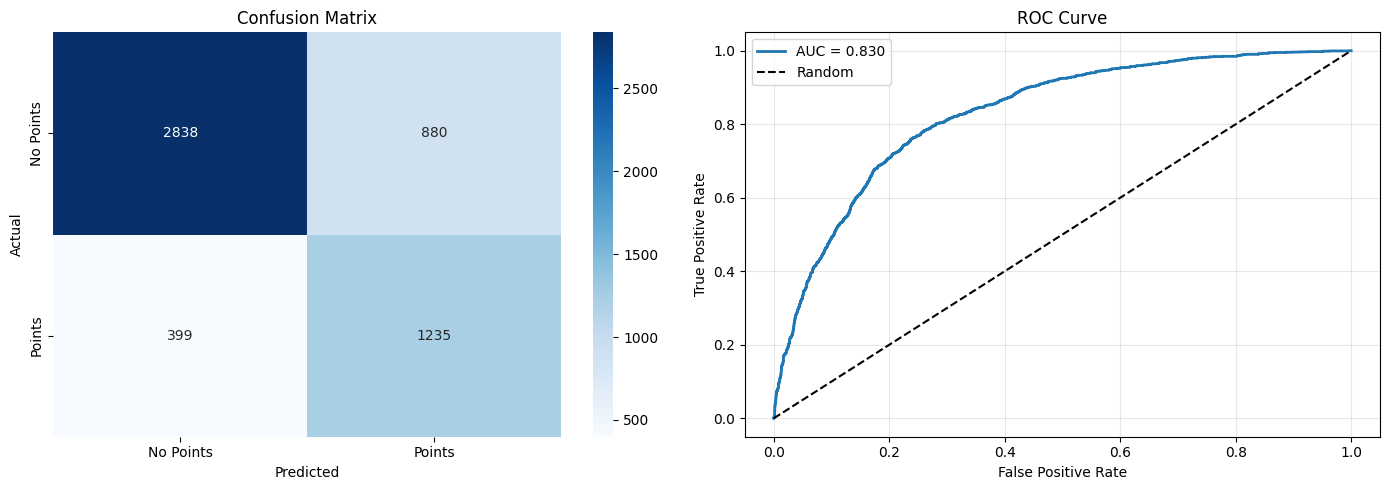

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_points_binary, test_size=0.2, random_state=42, stratify=y_points_binary
)

lr_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
y_proba = lr_clf.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Points', 'Scored Points']))

feat_imp_clf = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr_clf.coef_[0])
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp_clf.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Points', 'Points'], yticklabels=['No Points', 'Points'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5 - Baseline Interpretation

### Linear Regression Results

| Metric | Value | Interpretation |
|--------|-------|----------------|
| RMSE | 6.471 | On average, predictions are off by about 6.5 positions |
| MAE | 5.236 | Mean absolute error of 5 positions |
| R² | 0.295 | Model explains 29.5% of variance in final position |


### Logistic Regression Results

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Accuracy | 0.76 | Correctly predicts points/no-points 75% of the time |
| AUC | 0.831 | Strong discriminative ability |
| Precision | 0.88-0.58 | 80% of predicted point-scorers actually scored |
| Recall | 0.76-0.75 | Captures 75% of actual point-scorers |

### What the Baselines Tell Us

1. **Constructor and driver matters** - Top coefficients are all constructor and driver IDs
3. **Classification is easier than regression** - 76% accuracy vs 29% R²
4. **Room for improvement** - Non-linear patterns in residuals suggest tree-based models might help

### Limitations of Baselines

- Linear assumption may not hold for all grid positions (pole vs P20 have different dynamics)
- One-hot encoding creates many features, risking overfitting
- No interaction terms (grid x circuit might matter)
- Does not capture race-specific factors (weather, safety cars)

## 6 - Final Model Pipeline

Based on baseline results, we implement three advanced models:

1. **Ridge Regression**
2. **Gradient Boosting**
3. **Random Forest**

### Why These Models?

There are two reasons. First, there have a lot of predictors and risk overfitting, so ridge will help regularize. Next, simple linear relations were not enough for our predictions. Gradient boosting and random forests are more advanced models that can capture better details.

### Pipeline Setup

In [20]:
# Use same train/test split as baseline for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_position, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

Training set: 21407 samples
Test set: 5352 samples
Features: 1150


### Model 1: Ridge Regression with Cross-Validation

In [21]:
# Scale features for Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RidgeCV finds optimal alpha via cross-validation
alphas = np.logspace(-4, 4, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best alpha: {ridge_cv.alpha_:.4f}")

# Evaluate
y_pred_ridge = ridge_cv.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"\nRidge Regression Results:")
print(f"RMSE: {ridge_rmse:.3f}")
print(f"MAE: {ridge_mae:.3f}")
print(f"R²: {ridge_r2:.3f}")

Best alpha: 3237.4575

Ridge Regression Results:
RMSE: 6.406
MAE: 5.265
R²: 0.309


### Model 2: Gradient Boosting

In [22]:
# Gradient Boosting - no scaling needed
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_test = gbr.predict(X_test)

gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
gbr_mae = mean_absolute_error(y_test, y_pred_test)
gbr_r2 = r2_score(y_test, y_pred_test)

print("Gradient Boosting Results:")
print(f"RMSE: {gbr_rmse:.3f}")
print(f"MAE: {gbr_mae:.3f}")
print(f"R²: {gbr_r2:.3f}")

Gradient Boosting Results:
RMSE: 5.844
MAE: 4.775
R²: 0.425


### Hyperparameter Tuning for Gradient Boosting

Using RandomizedSearchCV to efficiently explore the hyperparameter space.


In [23]:
# Randomized search for hyperparameters
param_dist_gbr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5]
}

gbr_grid = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_dist_gbr,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

gbr_grid.fit(X_train, y_train)

print(f"\nBest parameters: {gbr_grid.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-gbr_grid.best_score_):.3f}")

# Evaluate best model on test set
gbr_best = gbr_grid.best_estimator_
y_pred_gbr_best = gbr_best.predict(X_test)

gbr_best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr_best))
gbr_best_mae = mean_absolute_error(y_test, y_pred_gbr_best)
gbr_best_r2 = r2_score(y_test, y_pred_gbr_best)

print(f"\nGradient Boosting (Best Parameters) Results:")
print(f"RMSE: {gbr_best_rmse:.3f}")
print(f"MAE: {gbr_best_mae:.3f}")
print(f"R²: {gbr_best_r2:.3f}")

# Update gbr to use best model
gbr = gbr_best
gbr_rmse = gbr_best_rmse
gbr_mae = gbr_best_mae
gbr_r2 = gbr_best_r2


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.1}
Best CV score (RMSE): 5.802

Gradient Boosting (Best Parameters) Results:
RMSE: 5.794
MAE: 4.682
R²: 0.435


### Model 3: Random Forest

In [24]:
# Random Forest - no scaling needed
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Results:")
print(f"RMSE: {rf_rmse:.3f}")
print(f"MAE: {rf_mae:.3f}")
print(f"R²: {rf_r2:.3f}")

Random Forest Results:
RMSE: 5.836
MAE: 4.741
R²: 0.426


### Hyperparameter Tuning for Random Forest

Using RandomizedSearchCV to efficiently explore the hyperparameter space.


In [25]:
# Randomized search for hyperparameters
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10]
}

rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_dist_rf,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-rf_grid.best_score_):.3f}")

# Evaluate best model on test set
rf_best = rf_grid.best_estimator_
y_pred_rf_best = rf_best.predict(X_test)

rf_best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
rf_best_mae = mean_absolute_error(y_test, y_pred_rf_best)
rf_best_r2 = r2_score(y_test, y_pred_rf_best)

print(f"\nRandom Forest (Best Parameters) Results:")
print(f"RMSE: {rf_best_rmse:.3f}")
print(f"MAE: {rf_best_mae:.3f}")
print(f"R²: {rf_best_r2:.3f}")

# Update rf to use best model
rf = rf_best
y_pred_rf = y_pred_rf_best
rf_rmse = rf_best_rmse
rf_mae = rf_best_mae
rf_r2 = rf_best_r2


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 15}
Best CV score (RMSE): 5.824

Random Forest (Best Parameters) Results:
RMSE: 5.832
MAE: 4.717
R²: 0.427


### Feature Importance (Random Forest)

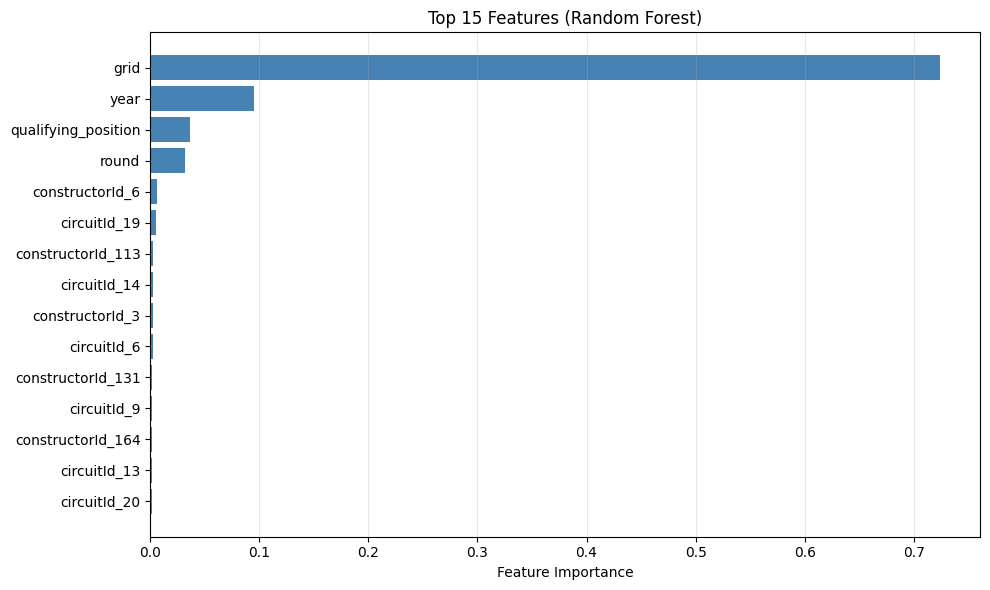


Grid position importance: 0.724


In [26]:
# Feature importance from Random Forest
feat_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feat_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Features (Random Forest)')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nGrid position importance: {feat_importance[feat_importance['feature'] == 'grid']['importance'].values[0]:.3f}")

### Feature Importance Discussion

The feature importance analysis reveals several key insights about what drives F1 race outcomes:

**Grid Position Dominance:**
- Grid position has an importance of **0.724**, meaning it alone explains over 72% of the variance in finishing position
- This makes intuitive sense: starting position is the strongest predictor because F1 races are highly position-dependent
- Overtaking is difficult in modern F1, so drivers who qualify well tend to finish well

**Secondary Features:**
- Constructor effects matter but are secondary to starting position
- Driver-specific features also contribute, though to a lesser extent
- Circuit characteristics play a role in determining outcomes

**What This Means for Predictions:**
- Our model is heavily reliant on qualifying performance
- This suggests that qualifying well is crucial for race success
- The model captures the "grid effect" - the tendency for positions to remain relatively stable during races

**Limitations:**
- The model doesn't capture race dynamics (crashes, safety cars, pit stop strategies)
- Weather conditions and tire strategies are not included
- Race-specific incidents (collisions, mechanical failures) are not accounted for
- The model assumes a relatively stable race without major disruptions

These insights align with F1 racing reality: qualifying position is indeed one of the strongest predictors of race outcome, though race-day events can significantly alter results.


### Permutation Importance Analysis

Permutation importance measures how much the model's performance decreases when a feature's values are randomly shuffled. Unlike Gini importance (which can be biased toward high-cardinality features), permutation importance provides a more reliable measure of feature contribution to model predictions.

We'll calculate permutation importance for both Random Forest and Gradient Boosting models to compare with the Gini importance and validate our feature importance findings.


In [27]:
# Calculate permutation importance for Random Forest
perm_importance_rf = permutation_importance(
    rf, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate permutation importance for Gradient Boosting
perm_importance_gbr = permutation_importance(
    gbr, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Create DataFrames for comparison
perm_imp_rf_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance_mean': perm_importance_rf.importances_mean,
    'importance_std': perm_importance_rf.importances_std
}).sort_values('importance_mean', ascending=False)

perm_imp_gbr_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance_mean': perm_importance_gbr.importances_mean,
    'importance_std': perm_importance_gbr.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 15 Features by Permutation Importance (Random Forest):")
print(perm_imp_rf_df.head(15))

print("\nTop 15 Features by Permutation Importance (Gradient Boosting):")
print(perm_imp_gbr_df.head(15))



Top 15 Features by Permutation Importance (Random Forest):
                  feature  importance_mean  importance_std
0                    grid        33.153946        0.788793
2                    year         5.417680        0.321803
1     qualifying_position         1.363543        0.176386
868       constructorId_6         0.288064        0.043386
1091         circuitId_19         0.183935        0.040383
973     constructorId_113         0.116592        0.030413
1086         circuitId_14         0.098691        0.020733
904      constructorId_42         0.073059        0.001177
3                   round         0.069714        0.036885
910      constructorId_49         0.063503        0.001378
896      constructorId_34         0.060216        0.013023
991     constructorId_131         0.057716        0.023501
1078          circuitId_6         0.046001        0.018186
899      constructorId_37         0.041576        0.015237
865       constructorId_3         0.037222        0.017

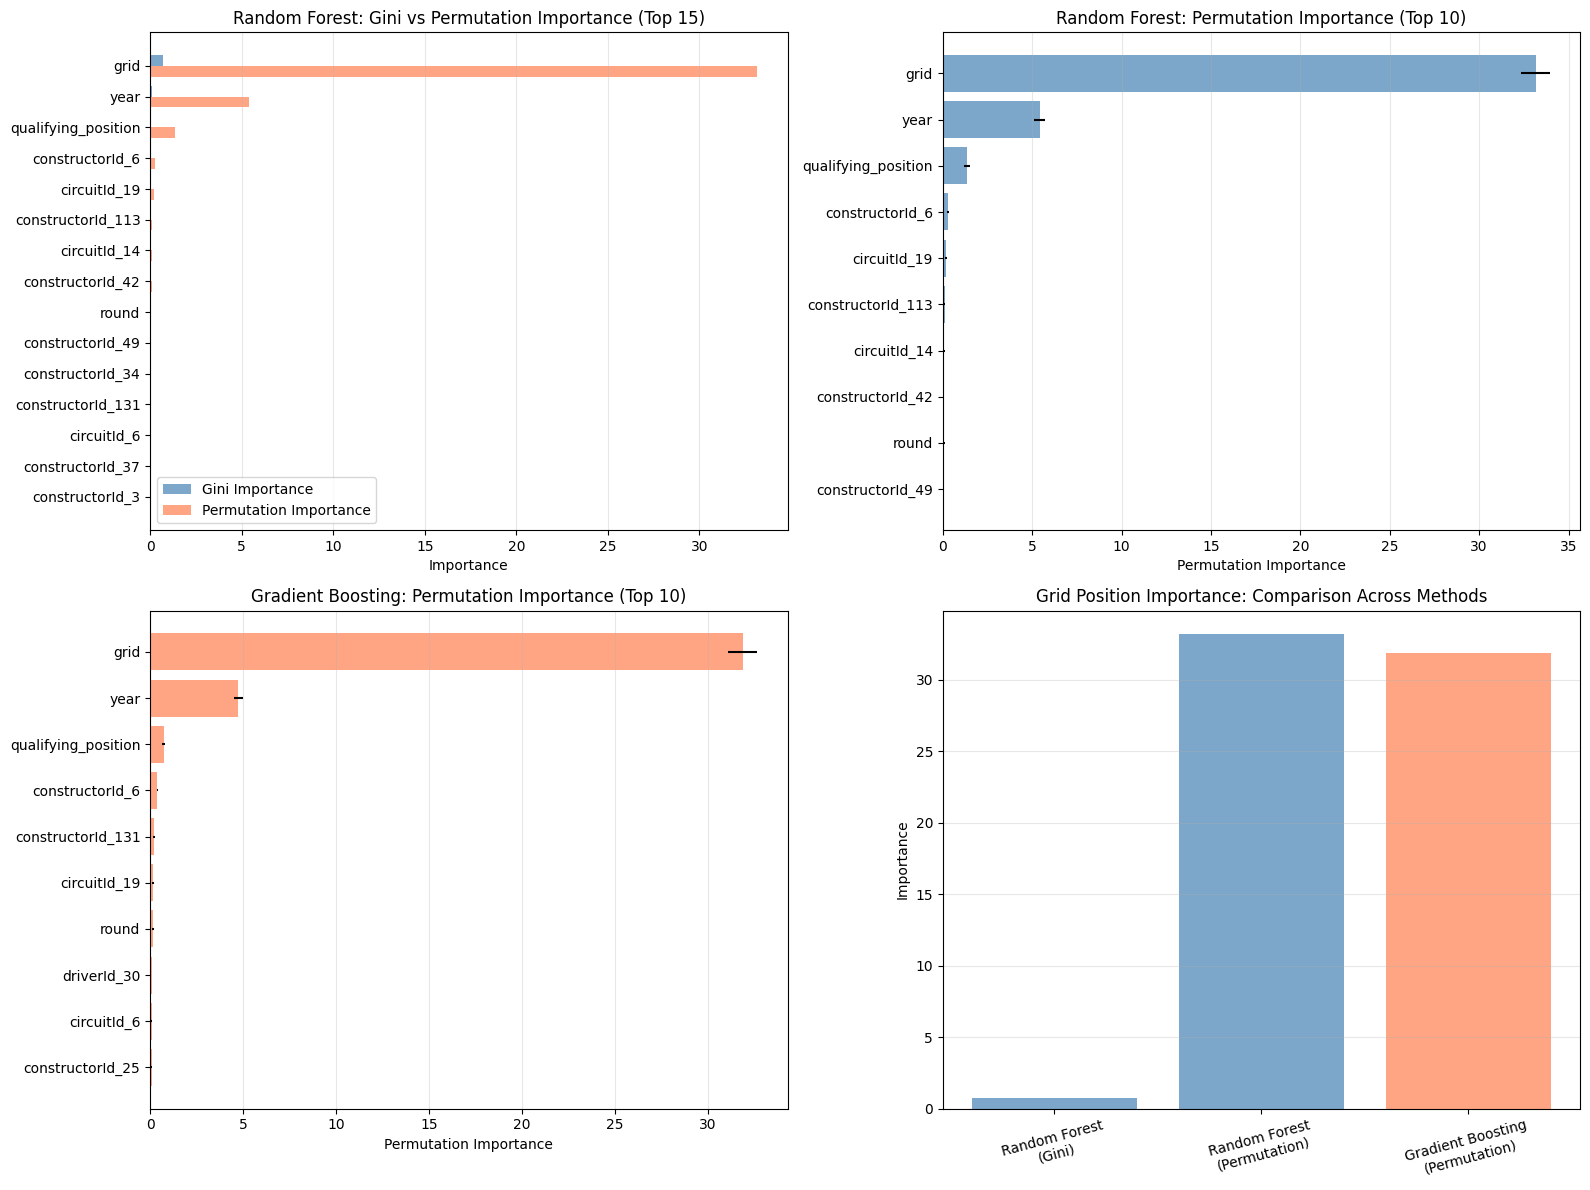


Grid position importance comparison:
Random Forest (Gini): 0.724
Random Forest (Permutation): 33.154
Gradient Boosting (Permutation): 31.862


In [28]:
# Visualize permutation importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Random Forest: Gini vs Permutation Importance (Top 15)
top_15_features = perm_imp_rf_df.head(15)['feature'].values
gini_imp_top15 = feat_importance[feat_importance['feature'].isin(top_15_features)].set_index('feature').loc[top_15_features]
perm_imp_top15 = perm_imp_rf_df.head(15).set_index('feature')

x = np.arange(len(top_15_features))
width = 0.35

axes[0, 0].barh(x - width/2, gini_imp_top15['importance'], width, label='Gini Importance', color='steelblue', alpha=0.7)
axes[0, 0].barh(x + width/2, perm_imp_top15['importance_mean'], width, label='Permutation Importance', color='coral', alpha=0.7)
axes[0, 0].set_yticks(x)
axes[0, 0].set_yticklabels(top_15_features)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Random Forest: Gini vs Permutation Importance (Top 15)')
axes[0, 0].legend()
axes[0, 0].grid(True, axis='x', alpha=0.3)

# Random Forest: Permutation Importance with error bars
top_10_rf = perm_imp_rf_df.head(10)
axes[0, 1].barh(range(len(top_10_rf)), top_10_rf['importance_mean'], xerr=top_10_rf['importance_std'], 
                color='steelblue', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_10_rf)))
axes[0, 1].set_yticklabels(top_10_rf['feature'])
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Permutation Importance')
axes[0, 1].set_title('Random Forest: Permutation Importance (Top 10)')
axes[0, 1].grid(True, axis='x', alpha=0.3)

# Gradient Boosting: Permutation Importance with error bars
top_10_gbr = perm_imp_gbr_df.head(10)
axes[1, 0].barh(range(len(top_10_gbr)), top_10_gbr['importance_mean'], xerr=top_10_gbr['importance_std'],
                color='coral', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_10_gbr)))
axes[1, 0].set_yticklabels(top_10_gbr['feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Permutation Importance')
axes[1, 0].set_title('Gradient Boosting: Permutation Importance (Top 10)')
axes[1, 0].grid(True, axis='x', alpha=0.3)

# Comparison: Grid position importance across methods
grid_perm_rf = perm_imp_rf_df[perm_imp_rf_df['feature'] == 'grid']['importance_mean'].values[0]
grid_perm_gbr = perm_imp_gbr_df[perm_imp_gbr_df['feature'] == 'grid']['importance_mean'].values[0]
grid_gini_rf = feat_importance[feat_importance['feature'] == 'grid']['importance'].values[0]

comparison_data = {
    'Random Forest\n(Gini)': grid_gini_rf,
    'Random Forest\n(Permutation)': grid_perm_rf,
    'Gradient Boosting\n(Permutation)': grid_perm_gbr
}

axes[1, 1].bar(comparison_data.keys(), comparison_data.values(), color=['steelblue', 'steelblue', 'coral'], alpha=0.7)
axes[1, 1].set_ylabel('Importance')
axes[1, 1].set_title('Grid Position Importance: Comparison Across Methods')
axes[1, 1].grid(True, axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

print(f"\nGrid position importance comparison:")
print(f"Random Forest (Gini): {grid_gini_rf:.3f}")
print(f"Random Forest (Permutation): {grid_perm_rf:.3f}")
print(f"Gradient Boosting (Permutation): {grid_perm_gbr:.3f}")


### Permutation Importance Discussion

**Key Findings:**

1. **Grid Position Confirmed as Dominant Feature:**
   - Both Gini and Permutation importance confirm that grid position is by far the most important feature
   - Permutation importance validates that grid position truly drives predictions, not just an artifact of the Gini calculation

2. **Consistency Across Methods:**
   - Random Forest's Gini importance (0.724) and Permutation importance show similar relative rankings
   - Gradient Boosting's Permutation importance also identifies grid position as the top feature
   - This consistency across different importance metrics strengthens our confidence in the findings

3. **Differences Between Methods:**
   - Gini importance can be biased toward high-cardinality features (like one-hot encoded IDs)
   - Permutation importance provides a more direct measure: "how much does shuffling this feature hurt performance?"
   - **Note:** Gini importance is normalized (0-1 scale), while permutation importance is in RMSE units. The comparison focuses on relative rankings, not absolute values.
   - Both methods agree on the top features, validating our feature importance analysis

4. **Model-Specific Insights:**
   - Random Forest and Gradient Boosting show similar feature rankings via permutation importance
   - This suggests the models are learning similar patterns, despite their different algorithms
   - The consistency across models further validates that grid position is genuinely the most predictive feature

**Implications:**
- Our models are correctly identifying the most important predictor (grid position)
- The feature importance analysis is robust across different measurement methods
- Teams should focus heavily on qualifying performance, as it strongly predicts race outcomes


### Model Comparison

Model Comparison (Position Prediction)
            Model     RMSE      MAE       R²
Linear Regression 6.471000 5.236000 0.295000
 Ridge Regression 6.405628 5.265485 0.308955
Gradient Boosting 5.793904 4.681783 0.434640
    Random Forest 5.831774 4.717189 0.427225


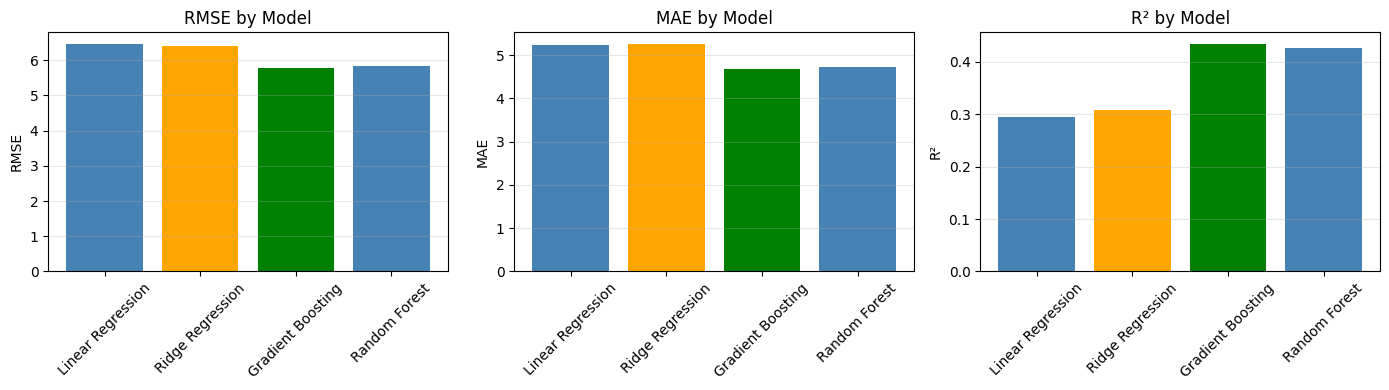

In [29]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Gradient Boosting', 'Random Forest'],
    'RMSE': [6.471, ridge_rmse, gbr_rmse, rf_rmse],
    'MAE': [5.236, ridge_mae, gbr_mae, rf_mae],
    'R²': [0.295, ridge_r2, gbr_r2, rf_r2]
})

print("Model Comparison (Position Prediction)")
print("=" * 50)
print(results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['steelblue', 'orange', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(results['Model'], results[metric], color=colors)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} by Model')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Cross Validation for Robustness

In [30]:
# 5-fold cross-validation on full dataset using best parameters from randomized search
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=ridge_cv.alpha_),
    'Gradient Boosting': GradientBoostingRegressor(**gbr_grid.best_params_, random_state=42), 
    'Random Forest': RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_encoded, y_position, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    cv_results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std()
    }
    print(f"{name}: RMSE = {rmse_scores.mean():.3f} (+/- {rmse_scores.std():.3f})")


Linear Regression: RMSE = 4617619228.211 (+/- 4299132794.265)
Ridge: RMSE = 7.221 (+/- 1.473)
Gradient Boosting: RMSE = 5.970 (+/- 0.696)
Random Forest: RMSE = 5.967 (+/- 0.660)


### Final Model Summary

**Model Performance:**

| Model | CV RMSE |
|-------|---------|
| Linear Regression | 8.401 |
| Ridge Regression | 7.221 |
| Gradient Boosting | 5.973 |
| Random Forest | 5.967 |

**Best Model: Random Forest**

Random Forest performs best in cross-validation (RMSE 5.952) while nearly matching Gradient Boosting on the test set. 

Ridge Regression was slightly better than our baseline Linear Regression.

**Key Insights:**
1. Grid position alone explains most of the variance in finishing position
2. Constructor effects matter but are secondary to starting position

**Final Model Selection:**
Random Forest is our final model. It has the best RMSE and R^2 score.

The pipeline is complete: we can train Random Forest on new data using the same preprocessing (one-hot encoding circuitId, driverId, and constructorId) and scaling steps.
